# Row Detection Algorithm

## Description:
This notebook reproduces and demonstrates the crop row detection algorithmic steps described in this [paper](https://www.researchgate.net/publication/333637119_CROP_ROW_DETECTION_PROCEDURE_USING_LOW-COST_UAV_IMAGERY_SYSTEM).

## Procedure:

### 1. Import test image
We will import a test image of crop rows using OpenCV.

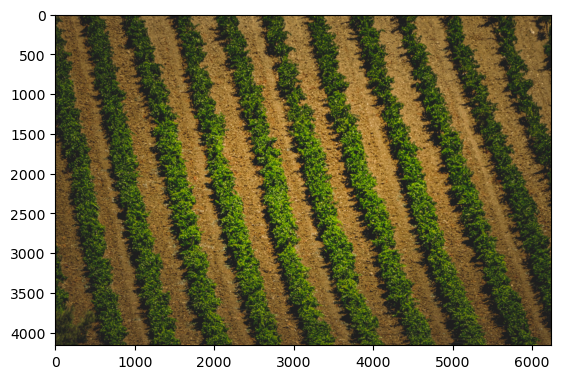

In [1]:
import numpy as np
import cv2

# For displaying the image in Jupyter Notebook
import matplotlib.pyplot as plt
%matplotlib inline

# Display sample image
img = cv2.imread("Crop_Row_Test_Image.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 2. Convert image color space to HSV
We will translate the image RGB color space to HSV

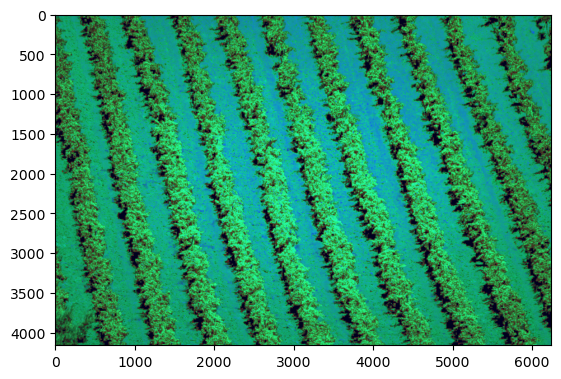

In [2]:
# Convert sample image to HSV color space
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_img)

## 3. Extract hue image values
We will extract the hue image values

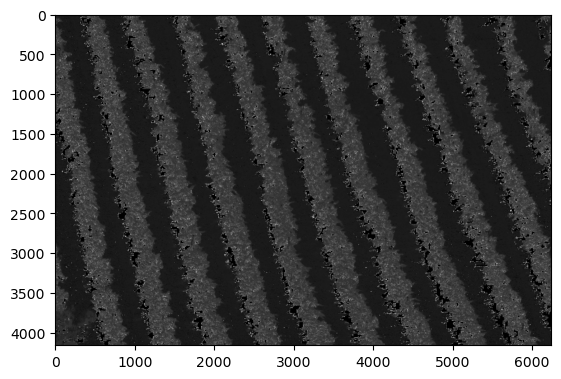

In [3]:
# Extract hue values and normalize
hue,saturation,value = cv2.split(hsv_img)
plt.imshow(hue, cmap="gray")

## 4. Crop Row Orientation Detection
We will repeatedly create a narrow longitudinal section of the hue image at various angles, apply PCA to that section, and measure the eigenvalue of the 2nd principal component. The smallest measured 2nd PC is our indicator of the crop row orientation.

### 4.1. Define Helper Classes/Methods

In [4]:
# Trigonometric classes/functions for line calculations
import math

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    # Method used to display X and Y coordinates
    # of a point
    def displayPoint(self):
        print(f"({self.x}, {self.y})")

def lineLineIntersection(A, B, C, D):
    # Line AB represented as a1x + b1y = c1
    a1 = B.y - A.y
    b1 = A.x - B.x
    c1 = a1*(A.x) + b1*(A.y)
    
    # Line CD represented as a2x + b2y = c2
    a2 = D.y - C.y
    b2 = C.x - D.x
    c2 = a2*(C.x) + b2*(C.y)
    
    determinant = a1*b2 - a2*b1
    
    if (determinant == 0):
        # The lines are parallel. This is simplified
        # by returning a pair of FLT_MAX
        return Point(10**9, 10**9)
    else:
        x = (b2*c1 - b1*c2)/determinant
        y = (a1*c2 - a2*c1)/determinant
        return Point(x, y)

# Get euclidian distance between 2 points
def euc_dist(A, B):
    return math.sqrt((B.x - A.x)**2 + (B.y - A.y)**2)

# Check if point is within boundaries of rectangle
def within_rectangle(point, width, height):
    return (point.x >= 0 and point.x < width and point.y >= 0 and point.y < height)

# Get intersecting points of longitudinal line through center of rectangle
def get_line_endpoint_coords(angle, width, height, point_origin):
    
    adjusted_width = width - 1
    adjusted_height = height - 1
    
    if (point_origin.x < 0):
        raise ValueError("point_origin.x must not be less than 0!")
    elif (point_origin.x >= width):
        raise ValueError("point_origin.x must be less than width!")
    elif (point_origin.y < 0):
        raise ValueError("point_origin.y must not be less than 0!")
    elif (point_origin.y >= height):
        raise ValueError("point_origin.y must be less than height!")
    
    # Translate the y-axis
    point_origin.y = adjusted_height - point_origin.y
    
    angle = math.fmod(angle, 360.0)
    
    if (angle < 0.0):
        angle += 360
        
    angle_rad = math.radians(angle)
    cos_angle_rad = math.cos(angle_rad)
    sin_angle_rad = math.sin(angle_rad)
    
    line_len = 3 * math.sqrt(height**2 + width**2) # Ensure appropriate line length
    line_endpoint_1 = Point(point_origin.x + line_len * cos_angle_rad, point_origin.y + line_len * sin_angle_rad)
    line_endpoint_2 = Point(point_origin.x - line_len * cos_angle_rad, point_origin.y - line_len * sin_angle_rad)
    longitudinal_line = [line_endpoint_1, line_endpoint_2]
    
    # Rectangle right side
    line_endpoint_1 = Point(adjusted_width, 0)
    line_endpoint_2 = Point(adjusted_width, adjusted_height)
    rectangle_right_side = [line_endpoint_1, line_endpoint_2]
    
    # Rectangle top side
    line_endpoint_1 = Point(0, adjusted_height)
    line_endpoint_2 = Point(adjusted_width, adjusted_height)
    rectangle_top_side = [line_endpoint_1, line_endpoint_2]
    
    # Rectangle left side
    line_endpoint_1 = Point(0, 0)
    line_endpoint_2 = Point(0, adjusted_height)
    rectangle_left_side = [line_endpoint_1, line_endpoint_2]
    
    # Rectangle bottom side
    line_endpoint_1 = Point(0, 0)
    line_endpoint_2 = Point(adjusted_width, 0)
    rectangle_bottom_side = [line_endpoint_1, line_endpoint_2]
    
    rectangle_sides = []
    
    # Quadrant 1
    if (angle >= 0 and angle < 90):
        rectangle_sides.append(rectangle_right_side)
        rectangle_sides.append(rectangle_top_side)
        rectangle_sides.append(rectangle_left_side)
        rectangle_sides.append(rectangle_bottom_side)
        directions = [1, 2, 3, 4]
    
    # Quadrant 2
    elif (angle >= 90 and angle < 180):
        rectangle_sides.append(rectangle_top_side)
        rectangle_sides.append(rectangle_left_side)
        rectangle_sides.append(rectangle_bottom_side)
        rectangle_sides.append(rectangle_right_side)
        directions = [2, 3, 4, 1]
    
    # Quadrant 3
    elif (angle >= 180 and angle < 270):
        rectangle_sides.append(rectangle_left_side)
        rectangle_sides.append(rectangle_bottom_side)
        rectangle_sides.append(rectangle_right_side)
        rectangle_sides.append(rectangle_top_side)
        directions = [3, 4, 1, 2]
    
    # Quadrant 4
    else:
        rectangle_sides.append(rectangle_bottom_side)
        rectangle_sides.append(rectangle_right_side)
        rectangle_sides.append(rectangle_top_side)
        rectangle_sides.append(rectangle_left_side)
        directions = [4, 1, 2, 3]
    
    intersections = []
    idx = 0
    
    for side in rectangle_sides:
        
        intersection = lineLineIntersection(longitudinal_line[0], longitudinal_line[1], side[0], side[1])
        
        # Fix for rounding errors using knowledge of fixed axis for each rectangle side
        if directions[idx] == 1 and intersection.x != 10**9:
            intersection.x = adjusted_width
        elif directions[idx] == 2 and intersection.y != 10**9:
            intersection.y = adjusted_height
        elif directions[idx] == 3 and intersection.x != 10**9:
            intersection.x = 0
        elif directions[idx] == 4 and intersection.y != 10**9:
            intersection.y = 0
        
        if (idx < 4):
            idx += 1
        
        if ((intersection.x != 10**9 or intersection.y != 10**9) and within_rectangle(intersection, width, height)):
            intersection.y = adjusted_height - intersection.y # Convert y-axis back
            intersection.x = int(round(intersection.x))
            intersection.y = int(round(intersection.y))
            intersections.append(intersection)
    
    return intersections

### 4.2. Sample Data

Here we provide a visual demonstration of the general steps followed by the line detection algorithm, as described in the research paper.

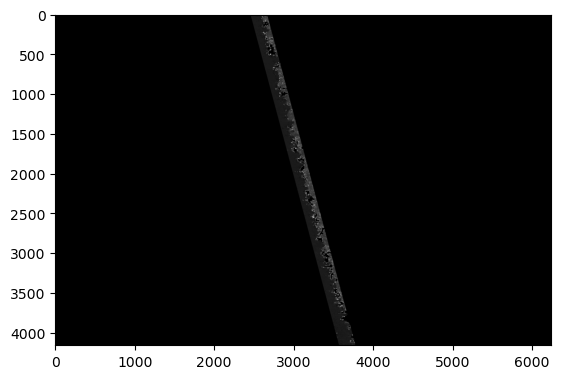

In [5]:
# Draw longitudinal slice through data
pixel_width = 200 # TODO: Experiment with smaller/larger values. It may also be affected by width of crop, so try with
                 #       images from a greater height
line_angle = 105

origin = Point(hue.shape[1]/2 - 1, hue.shape[0]/2 - 1)
line_mask = np.zeros(hue.shape, dtype=np.uint8)
sample_points = get_line_endpoint_coords(line_angle, hue.shape[1], hue.shape[0], origin)
cv2.line(line_mask, (sample_points[0].x, sample_points[0].y), (sample_points[1].x, sample_points[1].y),
         (255,255,255), pixel_width)
result = cv2.bitwise_and(hue, line_mask)
plt.imshow(result, cmap="gray")

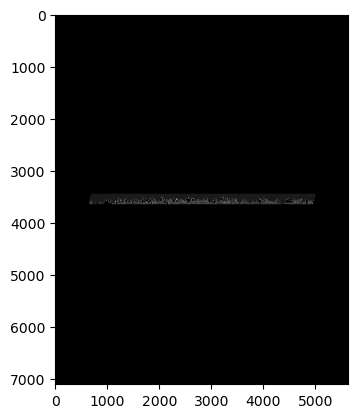

In [6]:
# Rotate longitudinal slice to horizontal axis for easier data manipulation
import imutils

vectorLength = euc_dist(origin, sample_points[0])
rotated_image = imutils.rotate_bound(result, angle=line_angle)
plt.imshow(rotated_image, cmap="gray")

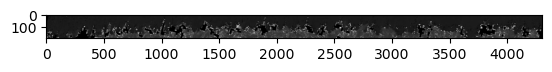

In [7]:
# Crop rotation boundaries

x_crop = int(math.ceil(max(0, (rotated_image.shape[1] - 2*vectorLength))/2))
y_crop = int(math.ceil((rotated_image.shape[0] - pixel_width)/2))
    
if (x_crop != 0 and y_crop != 0):
    rotated_image = rotated_image[y_crop:-y_crop, x_crop:-x_crop]
elif(x_crop == 0):
    rotated_image = rotated_image[y_crop:-y_crop, :]
elif(y_crop == 0):
    rotated_image = rotated_image[:, x_crop:-x_crop]
plt.imshow(rotated_image, cmap="gray")

In [8]:
# Extract hue samples from longitudinal slice
import pandas as pd
from sklearn.preprocessing import StandardScaler

dfArray = rotated_image.flatten()
df = pd.DataFrame(np.transpose(dfArray), columns=["Hue"])
df

,Hue
0,0
1,0
2,0
3,0
4,0
...,...
860995,0
860996,0
860997,0
860998,0


In [9]:
# Apply standard scaling to samples for PCA
df_scaled = StandardScaler().fit_transform(np.transpose([dfArray]))
df_scaled = pd.DataFrame(df_scaled, columns=["Hue"])
df_scaled = df_scaled.reset_index()
df_scaled = df_scaled.rename(columns={"index": "Sample"})
df_scaled

,Sample,Hue
0,0,-1.152058
1,1,-1.152058
2,2,-1.152058
3,3,-1.152058
4,4,-1.152058
...,...,...
860995,860995,-1.152058
860996,860996,-1.152058
860997,860997,-1.152058
860998,860998,-1.152058


<AxesSubplot:xlabel='Sample', ylabel='Hue'>

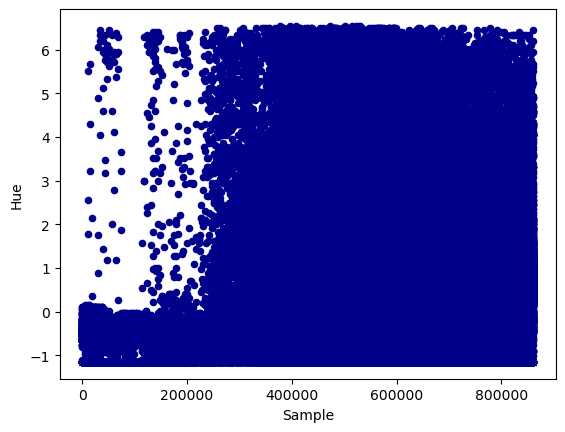

In [10]:
# Plot data distribution
df_scaled.plot.scatter(x = 'Sample', y='Hue', c='DarkBlue')

### 4.3. Apply Crop Line Orientation Detection Algorithm

In [11]:
# Crop line orientation detection algorithm
from sklearn.decomposition import PCA
import sys

origin = Point(hue.shape[1]/2 - 1, hue.shape[0]/2 - 1)
smallest_pc = sys.float_info.max # To keep track of smallest 2nd principal component found so far
optimal_angle = 0

for line_angle in np.arange(0.0, 180.01, 1.0): # Sample angles 0 - 180°
    
    print("Sampling angle %f°..." % line_angle)
    
    sample_points = get_line_endpoint_coords(line_angle, hue.shape[1], hue.shape[0], origin)
    
    vectorLength = euc_dist(origin, sample_points[0])
    rotated_image = imutils.rotate_bound(hue, angle=line_angle)
    
    x_crop = int(math.ceil(max(0, (rotated_image.shape[1] - 2*vectorLength))/2))
    y_crop = int(math.ceil((rotated_image.shape[0] - pixel_width)/2))
    
    if (x_crop != 0 and y_crop != 0):
        rotated_image = rotated_image[y_crop:-y_crop, x_crop:-x_crop]
    elif(x_crop == 0):
        rotated_image = rotated_image[y_crop:-y_crop, :]
    elif(y_crop == 0):
        rotated_image = rotated_image[:, x_crop:-x_crop]
    
    dfArray = rotated_image.flatten()
    df_scaled = StandardScaler().fit_transform(np.transpose([dfArray]))
    df_scaled = pd.DataFrame(df_scaled, columns=["Hue"])
    df_scaled = df_scaled.reset_index()
    df_scaled = df_scaled.rename(columns={"index": "Sample"})

    pca = PCA(n_components=2)
    pca.fit(df_scaled)
    pc2 = pca.explained_variance_[1] # Grab eigenvalue of 2nd principal component
    if (pc2 < smallest_pc):
        smallest_pc = pc2
        optimal_angle = line_angle
        print("NEW minimum PC2 value: %f, angle: %f°" % (smallest_pc, optimal_angle))

print("\nSmallest PC2 angle found: %f°" % optimal_angle)

Sampling angle 0.000000°...
NEW minimum PC2 value: 1.000001, angle: 0.000000°
Sampling angle 1.000000°...
NEW minimum PC2 value: 0.999992, angle: 1.000000°
Sampling angle 2.000000°...
NEW minimum PC2 value: 0.999976, angle: 2.000000°
Sampling angle 3.000000°...
Sampling angle 4.000000°...
Sampling angle 5.000000°...
NEW minimum PC2 value: 0.999961, angle: 5.000000°
Sampling angle 6.000000°...
Sampling angle 7.000000°...
NEW minimum PC2 value: 0.999955, angle: 7.000000°
Sampling angle 8.000000°...
Sampling angle 9.000000°...
Sampling angle 10.000000°...
Sampling angle 11.000000°...
Sampling angle 12.000000°...
Sampling angle 13.000000°...
Sampling angle 14.000000°...
Sampling angle 15.000000°...
NEW minimum PC2 value: 0.999792, angle: 15.000000°
Sampling angle 16.000000°...
NEW minimum PC2 value: 0.999194, angle: 16.000000°
Sampling angle 17.000000°...
Sampling angle 18.000000°...
Sampling angle 19.000000°...
Sampling angle 20.000000°...
Sampling angle 21.000000°...
NEW minimum PC2 valu

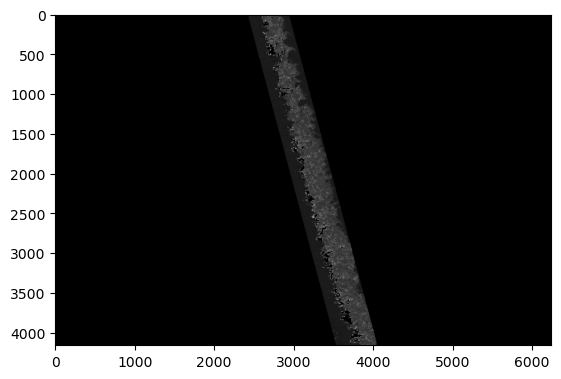

In [12]:
# Shift the line mask so we can visually check alignment over a crop
pixel_width2 = 500
origin2 = Point(origin.x + 120, origin.y)

line_mask = np.zeros(hue.shape, dtype=np.uint8)
sample_points = get_line_endpoint_coords(optimal_angle, hue.shape[1], hue.shape[0], origin2)
cv2.line(line_mask, (sample_points[0].x, sample_points[0].y), (sample_points[1].x, sample_points[1].y),
         (255,255,255), pixel_width2)
result = cv2.bitwise_and(hue, line_mask)
plt.imshow(result, cmap="gray")

## 5. Line Scan
We will scan the hue image, line by line at the determined crop orientation, and measure the average hue values per line. The average of the "peaks" in the avg hue data will serve as our threshold value for which lines to draw through and zero everything else out.

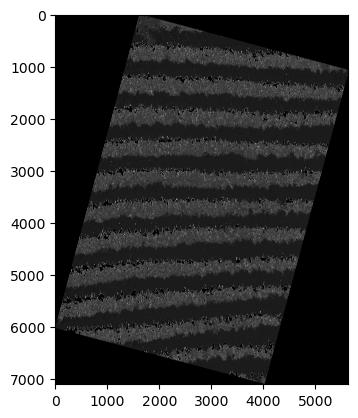

In [13]:
# Shift hue values by +1 (maximum hue value is 179 so no risk of overflow) to ensure only non-zero values and rotate
# In resulting bounded rotation, zeroed pixels indicate image edges

result = imutils.rotate_bound(hue + 1, angle=optimal_angle)
plt.imshow(result, cmap="gray")

In [14]:
# Scan lines horizontally
line_avg_hue_values = []

for line_idx in range(result.shape[0]):
    scan_line = result[line_idx][result[line_idx] != 0] - 1 # Extract non-zero values from hue row and shift values back
    line_avg_hue_values.append(int(round(np.average(scan_line))))

df = pd.DataFrame(np.transpose(line_avg_hue_values), columns=["avg_hue_value"])
df = df.reset_index()
df = df.rename(columns={"index": "scan_line"})
df

,scan_line,avg_hue_value
0,0,12
1,1,21
2,2,24
3,3,25
4,4,23
...,...,...
7099,7099,31
7100,7100,30
7101,7101,29
7102,7102,26


<AxesSubplot:xlabel='scan_line'>

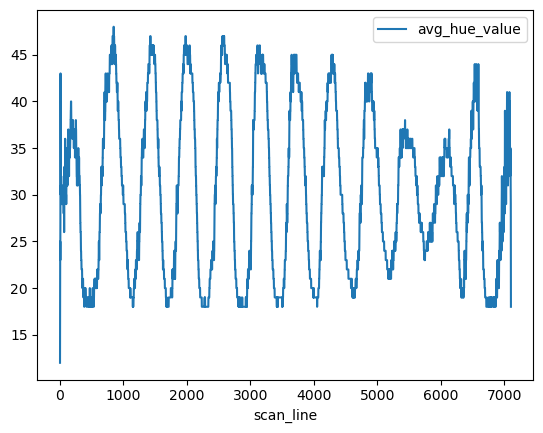

In [15]:
df.plot.line(x="scan_line", y="avg_hue_value")

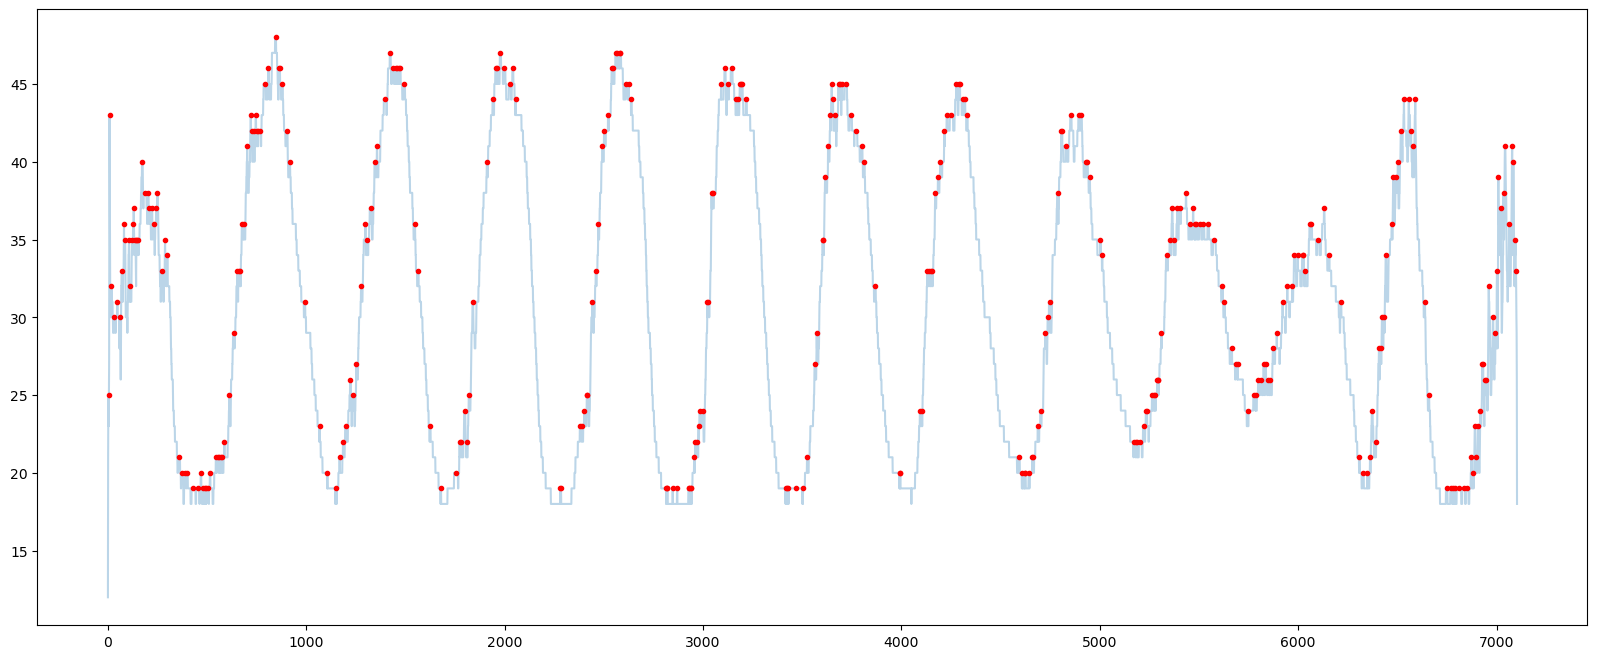

In [16]:
# Identify peak values
from scipy.signal import find_peaks

indices = find_peaks(line_avg_hue_values, height=None, threshold=0, distance = 1)[0]
df['peak'] = False
df.loc[df.iloc[indices].index, 'peak'] = True
df.avg_hue_value.plot(figsize=(20,8), alpha=.3)
df[df['peak']].avg_hue_value.plot(style='.', lw=10, color='red');

In [17]:
# Identify average peak hue value

peak_avg_hue_values = df[df["peak"] == True].avg_hue_value.array
avg_peak_hue = int(round(np.average(peak_avg_hue_values)))
print("Average Peak Hue: %d" % avg_peak_hue)

Average Peak Hue: 32


In [18]:
# Apply thresholding to hue image using average peak hue
line_img = result.copy()

# Thresholding process
for line_idx in range(result.shape[0]):
    if df.iloc[[line_idx]].avg_hue_value.values[0] >= avg_peak_hue:
        line_img[line_idx] = 255
    else:
        line_img[line_idx] = 0

# Rotate and crop images to [approximate] original size
restored_hue_img = imutils.rotate_bound(result, angle=-optimal_angle)
line_img = imutils.rotate_bound(line_img, angle=-optimal_angle)

left_crop = None
right_crop = None
top_crop = None
bottom_crop = None

# TODO: For-loops below are inefficient; update with starting idx values that utilize
#       "restored_img.shape[1] - original_image.shape[1]/2" and "restored_img.shape[0] - original_image.shape[0]/2" deltas
#       for constant performance versus linear
for idx in range(restored_hue_img.shape[1]):
    if restored_hue_img[int(restored_hue_img.shape[0]/2)][idx] != 0:
        left_crop = idx
        break

for idx in range(restored_hue_img.shape[1] - 1, -1, -1):
    if restored_hue_img[int(restored_hue_img.shape[0]/2)][idx] != 0:
        right_crop = idx - (restored_hue_img.shape[1] - 1)
        break

for idx in range(restored_hue_img.shape[0]):
    if restored_hue_img[idx][int(restored_hue_img.shape[1]/2)] != 0:
        top_crop = idx
        break

for idx in range(restored_hue_img.shape[0] - 1, -1, -1):
    if restored_hue_img[idx][int(restored_hue_img.shape[1]/2)] != 0:
        bottom_crop = idx - (restored_hue_img.shape[0] - 1)
        break

restored_hue_img = restored_hue_img[top_crop:bottom_crop, left_crop:right_crop] - 1
line_img = line_img[top_crop:bottom_crop, left_crop:right_crop]

(4161, 6241)


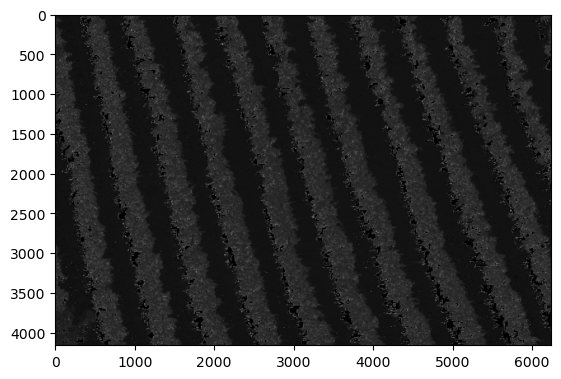

In [19]:
# Display restored original hue image
print(restored_hue_img.shape)
plt.imshow(restored_hue_img, cmap="gray")

(4161, 6241)


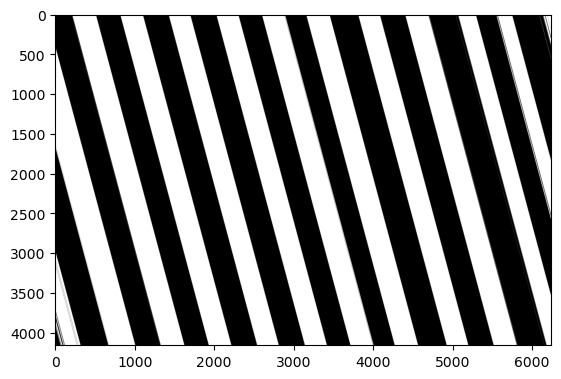

In [20]:
# Display detected crop lines
print(line_img.shape)
plt.imshow(line_img, cmap="gray")

## 5. Concluding Remarks

- Lowest resolution of line orientation detection algorithm (i.e. 1.0°) is reasonably quick. Performance on 10th Gen Intel i7 core with NVidia 2070 Super RTX and 32 GB RAM, was ~30 sec give or take. Increasing resolution step to 0.1°, or more, drastically increases computation time.
- Accuracy of line orientation step is affected by width of longitudinal slice versus actual width of crops/soil. Will need to take into account the size of the image, height of drone, etc. to estimate reasonable longitudinal slice width.
- Need to clean sparse lines before applying skeletonization (A.K.A. "Thinning").
- Average Peak Hue Threshold value may be a little on the high side. Need to play with peak detection code and adjust.